The beginning of this notebook is rough work and code kept for reference. The final analysis begins at the heading below.

In [5]:
sub2_fmri = 'sub-01_func_sub-01_task-LISTEN01_bold.nii.gz'


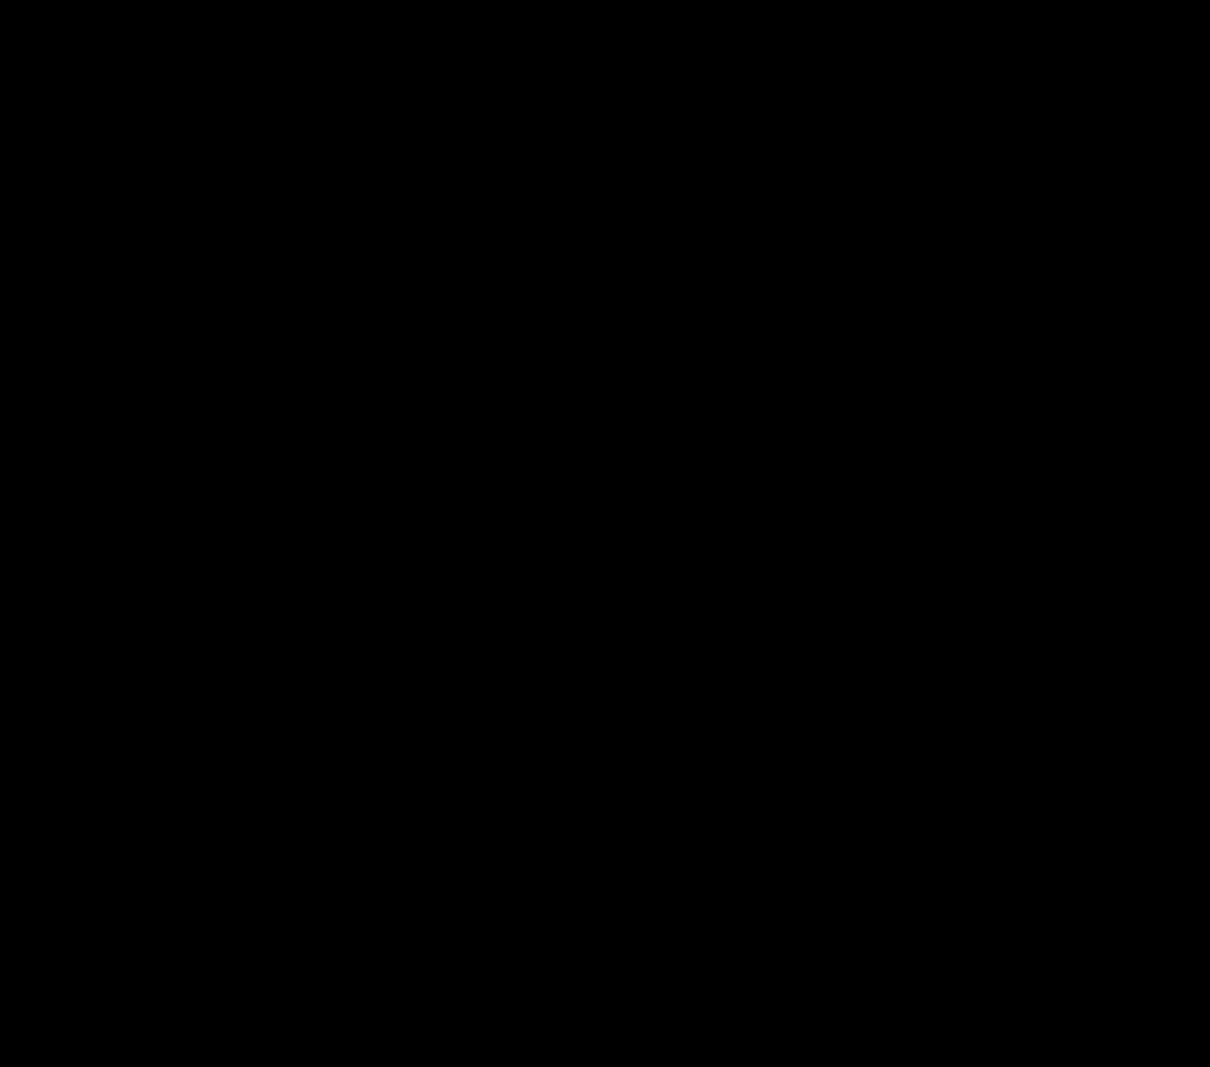
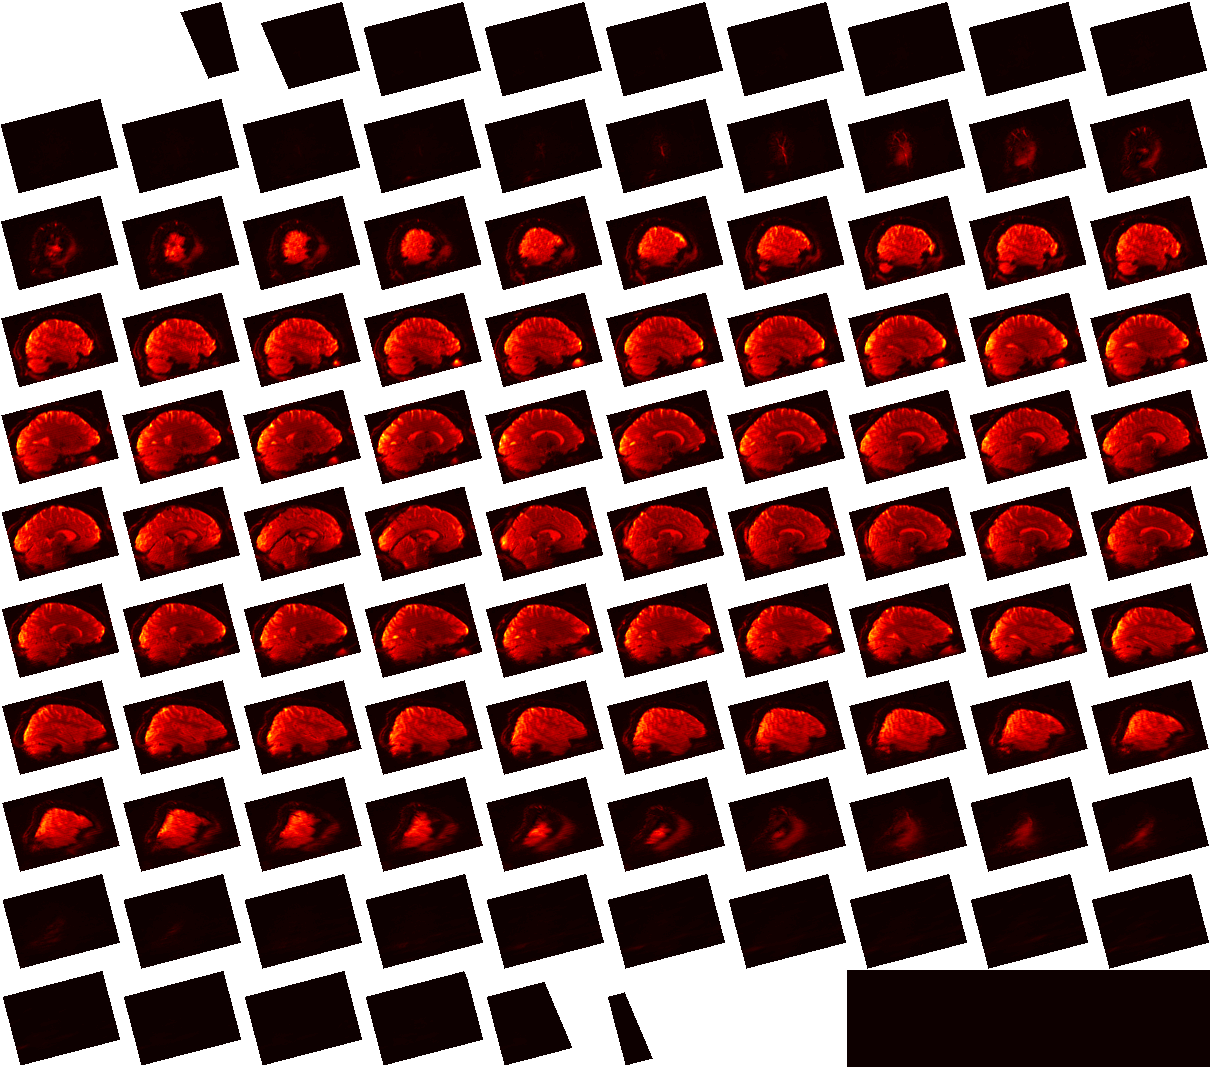

In [3]:
from nilearn import plotting
from nilearn.image import mean_img
from nilearn.image import smooth_img
#smoothed_img = smooth_img('ds002725-download/sub-02/anat/sub-02_T1w.nii.gz', fwhm = 3)
plotting.view_img(mean_img(sub2_fmri), threshold=None, bg_img=False)
#plotting.view_img(smoothed_img)

In [6]:
from nilearn import masking
from nilearn.input_data import NiftiMasker

mask = masking.compute_epi_mask(sub2_fmri)
masker = NiftiMasker(mask_img=mask, standardize=True)
fmri_masked = masker.fit_transform(sub2_fmri)
masker.generate_report()

/home/aalbury/miniconda3/lib/python3.7/site-packages/nilearn/image/resampling.py:513: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/aalbury/miniconda3/lib/python3.7/site-packages/nilearn/image/resampling.py:513: UserWarning: Casting data from int8 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


Parameter,Value
detrend,False
dtype,None
high_pass,None
low_pass,None
mask_args,None
mask_img,"<class 'nibabel.nifti1.Nifti1Image'> data shape (104, 104, 72) affine: [[-1.99942422e+00 -4.74683046e-02 -7.01117516e-03 1.07939171e+02] [-4.41753864e-02 1.93508792e+00 -5.03471494e-01 -7.82872314e+01] [-1.87330246e-02 5.03171802e-01 1.93557930e+00 -5.77198830e+01] [ 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00]] metadata: <class 'nibabel.nifti1.Nifti1Header'> object, endian='<' sizeof_hdr : 348 data_type : b'' db_name : b'' extents : 0 session_error : 0 regular : b'' dim_info : 0 dim : [ 3 104 104 72 1 1 1 1] intent_p1 : 0.0 intent_p2 : 0.0 intent_p3 : 0.0 intent_code : none datatype : int8 bitpix : 8 slice_start : 0 pixdim : [-1. 1.9999999 2. 2. 1. 1. 1. 1. ] vox_offset : 0.0 scl_slope : nan scl_inter : nan slice_end : 0 slice_code : unknown xyzt_units : 0 cal_max : 0.0 cal_min : 0.0 slice_duration : 0.0 toffset : 0.0 glmax : 0 glmin : 0 descrip : b'' aux_file : b'' qform_code : unknown sform_code : aligned quatern_b : -0.011549619 quatern_c : 0.99184746 quatern_d : 0.12686467 qoffset_x : 107.93917 qoffset_y : -78.28723 qoffset_z : -57.719883 srow_x : [-1.9994242e+00 -4.7468305e-02 -7.0111752e-03 1.0793917e+02] srow_y : [-4.4175386e-02 1.9350879e+00 -5.0347149e-01 -7.8287231e+01] srow_z : [-1.8733025e-02 5.0317180e-01 1.9355793e+00 -5.7719883e+01] intent_name : b'' magic : b'n+1'"
mask_strategy,background
memory,Memory(location=None)
memory_level,1
reports,True


In [5]:
print(fmri_masked.shape)

(185, 178337)


In [1]:
import pandas as pd
# Load behavioral information
events = pd.read_table('sub-01_func_sub-01_task-LISTEN01_events.tsv', delimiter='\t')

In [2]:
events.head()

,onset,duration,weight,trial_type,auxillary,Word,Concreteness,Log_Freq,DenB,Freq_Den_Interxn
0,0.00,0,1,ListenWord,NaN,dike,4.54,5.20,19,98.80
1,3.07,0,1,NaN,NaN,NaN,-1.00,-1.00,-1,-1.00
2,6.14,0,1,ListenWord,NaN,robe,5.00,7.40,18,133.20
3,9.21,0,1,NaN,NaN,NaN,-1.00,-1.00,-1,-1.00
4,12.28,0,1,ListenWord,NaN,sap,4.37,8.22,27,221.94


In [3]:
print(events.shape)

(180, 10)


In [8]:
pd.DataFrame(fmri_masked)

,0,1,2,3,4,5,6,7,8,9,...,178327,178328,178329,178330,178331,178332,178333,178334,178335,178336
0,1.486564,1.606282,1.435931,1.758632,0.851387,-1.700291,-0.102204,-1.362076,-1.767103,1.669166,...,1.536333,0.241984,1.659198,0.014884,-0.123523,0.962619,1.807987,1.363071,-1.216254,-0.770111
1,1.381216,1.444481,1.525331,1.568491,0.902374,-1.494146,0.455688,-1.299246,-1.494802,1.530209,...,1.441121,0.080577,2.191943,-0.272802,-0.594874,1.445527,1.544174,1.118287,-1.181724,-0.613067
2,1.500539,1.542473,1.537152,1.753693,1.029189,-1.755064,0.268883,-1.373421,-1.377469,1.356513,...,1.435719,0.330498,1.329574,0.118838,-0.507587,1.317698,1.198071,1.468569,-0.306972,-1.147018
3,1.432815,1.540194,1.160342,1.355303,0.923292,-1.760043,0.758616,-1.527879,-1.200363,1.556264,...,1.482312,0.671537,1.387481,-0.628178,-1.821259,1.104650,1.219853,1.345143,-0.475784,-1.449328
4,1.537088,1.518165,1.640591,1.668089,0.782096,-1.636555,0.246163,-1.474648,-1.563431,1.408622,...,1.450574,0.166487,2.329138,-0.113245,-0.525044,0.775610,0.879800,1.572688,-0.069101,-0.754407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,-1.058989,-1.036466,-0.887736,-1.046565,-1.122739,0.632039,-0.846902,1.030725,-0.013749,-1.380442,...,-0.705551,-0.696522,-0.744388,2.079452,-0.350470,-0.947711,-1.257329,-1.073046,-0.460437,1.251834
181,-0.687046,-0.959743,-0.879608,-0.935444,-1.270472,0.605150,-1.255855,1.037706,0.021672,-1.239004,...,-0.742691,-0.104261,-0.837930,1.201890,-0.350470,-1.866185,-1.404968,-1.130967,-0.886303,0.584396
182,-1.177237,-1.025071,-1.045848,-1.142048,-1.471807,0.711709,-1.271002,0.996692,-0.235133,-1.224115,...,-0.875043,-0.772019,-0.805859,1.878797,-0.481401,-0.912203,-0.937849,-1.008919,-0.878630,1.208647
183,-0.895592,-0.946070,-0.853749,-0.942852,-1.490110,0.527472,-1.324014,1.102282,0.568488,-1.073992,...,-0.809542,-0.182361,-0.935927,1.271998,0.072873,-1.186799,-1.112111,-1.011678,0.882384,0.454834


In [13]:
#Trying an atlas
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker

parcellations = datasets.fetch_atlas_basc_multiscale_2015(version='sym')
atlas_filename = parcellations.scale064

from nilearn import masking
from nilearn.input_data import NiftiMasker

masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True)
fmri_masked = masker.fit_transform(sub2_fmri)


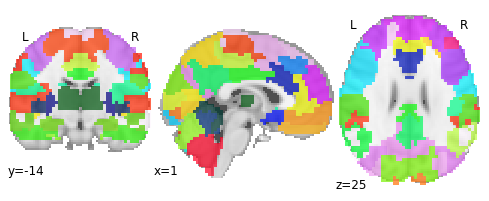

In [15]:
from nilearn import plotting
plotting.plot_roi(atlas_filename, draw_cross = False)

In [48]:
print(fmri_masked.shape)

(185, 64)


In [45]:
#THIS WORKS
#If word was presented replace null in next NaN in following row with word from previous
#May be useful for monitoring activity both before and after word
for i in events.index:
    if events.loc[i, 'trial_type'] == 'ListenWord':
        events.loc[i+1, 'Word'] = events.loc[i, 'Word']
        events.loc[i+1, 'trial_type'] = 'AfterWord'

In [46]:
events.head(10)

,onset,duration,weight,trial_type,auxillary,Word,Concreteness,Log_Freq,DenB,Freq_Den_Interxn
0,0.000,0,1,ListenWord,NaN,dike,4.54,5.20,19,98.80
1,3.070,0,1,AfterWord,NaN,dike,-1.00,-1.00,-1,-1.00
2,6.140,0,1,ListenWord,NaN,robe,5.00,7.40,18,133.20
3,9.210,0,1,AfterWord,NaN,robe,-1.00,-1.00,-1,-1.00
4,12.280,0,1,ListenWord,NaN,sap,4.37,8.22,27,221.94
5,15.350,0,1,AfterWord,NaN,sap,-1.00,-1.00,-1,-1.00
6,18.419,0,1,ListenNoise,NaN,NaN,-1.00,-1.00,-1,-1.00
7,21.489,0,1,NaN,NaN,NaN,-1.00,-1.00,-1,-1.00
8,24.559,0,1,ListenWord,NaN,Pope,4.71,9.01,22,198.22
9,27.629,0,1,AfterWord,NaN,Pope,-1.00,-1.00,-1,-1.00


In [ ]:
sub1 = '/mnt/d/data/ds002382-download/sub-01/func/sub-01_task-LISTEN02_bold.nii.gz'

from nilearn import plotting
from nilearn.image import mean_img
from nilearn.image import smooth_img
#smoothed_img = smooth_img('ds002725-download/sub-02/anat/sub-02_T1w.nii.gz', fwhm = 3)
plotting.view_img(mean_img(sub1), threshold=None, bg_img=False)
#plotting.view_img(smoothed_img)

# Predicting Schizophrenia Diagnosis

In [51]:
#import data
from nilearn import datasets
data = datasets.fetch_cobre()


Dataset created in /home/aalbury/nilearn_data/cobre



Downloaded 87892 of 87892 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 2239 of 2239 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)
Extracting data from /home/aalbury/nilearn_data/cobre/bbfb27073f7305ba75f231550ad51673/phenotypic_data.tsv.gz..... done.
/home/aalbury/miniconda3/lib/python3.7/site-packages/numpy/lib/npyio.py:2372: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


Downloaded 4575042 of 4575042 bytes (100.0%,    0.0s remaining) ...done. (4 seconds, 0 min)


Downloaded 24172 of 24172 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)
Extracting data from /home/aalbury/nilearn_data/cobre/0cd5e97478f9a8e664a01eb1c6ba17e1/fmri_0040046.tsv.gz..... done.


Downloaded 4479849 of 4479849 bytes (100.0%,    0.0s remaining) ...done. (4 seconds, 0 min)


Downloaded 24103 of 24103 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)
Extracting data from /home/aalbury/nilearn_data/cobre/0822cabbe39213c28b7a33bea04f0ae9/fmri_0040002.tsv.gz..... done.


Downloaded 4446722 of 4446722 bytes (100.0%,    0.0s remaining) ...done. (4 seconds, 0 min)


Downloaded 23998 of 23998 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)
Extracting data from /home/aalbury/nilearn_data/cobre/3ea49b064cdc65d4ac19c58b94369d5a/fmri_0040117.tsv.gz..... done.


Downloaded 4614105 of 4614105 bytes (100.0%,    0.0s remaining) ...done. (5 seconds, 0 min)


Downloaded 23920 of 23920 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)
Extracting data from /home/aalbury/nilearn_data/cobre/4abc23195f714fbb210d677f34285d5d/fmri_0040145.tsv.gz..... done.


Downloaded 4560443 of 4560443 bytes (100.0%,    0.0s remaining) ...done. (5 seconds, 0 min)


Downloaded 23847 of 23847 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)
Extracting data from /home/aalbury/nilearn_data/cobre/a7b5152347d1e56591484acae177b77d/fmri_0040000.tsv.gz..... done.


Downloaded 4647995 of 4647995 bytes (100.0%,    0.0s remaining) ...done. (5 seconds, 0 min)


Downloaded 24099 of 24099 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)
Extracting data from /home/aalbury/nilearn_data/cobre/fdbfd280ff5322077b5eff6994660f90/fmri_0040061.tsv.gz..... done.


Downloaded 4595137 of 4595137 bytes (100.0%,    0.0s remaining) ...done. (6 seconds, 0 min)


Downloaded 23958 of 23958 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)
Extracting data from /home/aalbury/nilearn_data/cobre/17ca77ec81f75b50b825727c4aab1df2/fmri_0040090.tsv.gz..... done.


Downloaded 4593987 of 4593987 bytes (100.0%,    0.0s remaining) ...done. (4 seconds, 0 min)


Downloaded 23936 of 23936 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)
Extracting data from /home/aalbury/nilearn_data/cobre/76e2655b3aa1b303589dfdef904ebcff/fmri_0040113.tsv.gz..... done.


Downloaded 4525595 of 4525595 bytes (100.0%,    0.0s remaining) ...done. (4 seconds, 0 min)


Downloaded 24037 of 24037 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)
Extracting data from /home/aalbury/nilearn_data/cobre/433e5c0cba0e8bdc641c5a8adbb3c990/fmri_0040121.tsv.gz..... done.


Downloaded 4551063 of 4551063 bytes (100.0%,    0.0s remaining) ...done. (4 seconds, 0 min)


Downloaded 23924 of 23924 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)
Extracting data from /home/aalbury/nilearn_data/cobre/bfac74090e10957abb67237a9a6a5655/fmri_0040020.tsv.gz..... done.


Downloaded 1543 of 1543 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 1268 of 1268 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


In [61]:
#import atlas
parcellations = datasets.fetch_atlas_basc_multiscale_2015(version='sym')
atlas_filename = parcellations.scale064

In [62]:
# create mask
from nilearn.input_data import NiftiLabelsMasker

mask = NiftiLabelsMasker(labels_img=atlas_filename, 
                           standardize=True, 
                           memory='nilearn_cache', 
                           verbose=1)

In [67]:

conf = data.confounds
#TIME SERIES OF ONE SUBJECT [MAKE SURE TO CHANGE]
time_series = masker.fit_transform(data.func[0], confounds=conf)

In [68]:
print(time_series.shape)

(150, 64)


In [146]:
#import phenotypic data
import pandas
pheno = pandas.DataFrame(data.phenotypic)

In [147]:
#extract participant id from file paths
file_names = []
for path in data.func:
    
    file_names.append(path[40:45])

In [148]:
#create dataframe of file paths and ids
files = pandas.DataFrame(data.func, columns = ['path'])
files['id'] = file_names
files['id'] = files.id.astype(int)

In [149]:
#merge phenotypic data with file paths
import pandas
pheno = pandas.merge(pheno, files, on = 'id')
#fix string decoding
pheno['gender'] = pheno['gender'].map(lambda gender: gender.decode('utf-8'))
pheno['handedness'] = pheno['handedness'].map(lambda gender: gender.decode('utf-8'))
pheno['subject_type'] = pheno['subject_type'].map(lambda gender: gender.decode('utf-8'))
pheno['diagnosis'] = pheno['diagnosis'].map(lambda gender: gender.decode('utf-8'))

In [150]:
pheno

,id,current_age,gender,handedness,subject_type,diagnosis,frames_ok,fd,fd_scrubbed,path
0,40061,18,Male,Right,Control,None,133,0.25512,0.22657,/home/aalbury/nilearn_data/cobre/fmri_0040061....
1,40090,18,Female,Right,Control,None,150,0.16963,0.16963,/home/aalbury/nilearn_data/cobre/fmri_0040090....
2,40046,18,Male,Left,Patient,295.70 depressed type,76,0.37504,0.30042,/home/aalbury/nilearn_data/cobre/fmri_0040046....
3,40002,19,Male,Right,Patient,295.3,67,0.40006,0.21575,/home/aalbury/nilearn_data/cobre/fmri_0040002....
4,40117,19,Male,Right,Patient,295.3,133,0.20975,0.18410,/home/aalbury/nilearn_data/cobre/fmri_0040117....
5,40145,19,Male,Right,Patient,295.6,144,0.16429,0.15521,/home/aalbury/nilearn_data/cobre/fmri_0040145....
6,40113,20,Male,Right,Control,None,126,0.19962,0.15790,/home/aalbury/nilearn_data/cobre/fmri_0040113....
7,40000,20,Female,Right,Patient,295.9,140,0.21234,0.20245,/home/aalbury/nilearn_data/cobre/fmri_0040000....
8,40121,21,Female,Right,Control,None,145,0.25869,0.25791,/home/aalbury/nilearn_data/cobre/fmri_0040121....
9,40020,22,Male,Right,Control,None,135,0.20898,0.19203,/home/aalbury/nilearn_data/cobre/fmri_0040020....


In [155]:
#create lists of filepaths for patients and controls
patients = []
controls = []

for i in pheno.index:
    if pheno.loc[i, 'subject_type']=='Patient':
    
        patients.append(pheno.loc[i, 'path'])
    else:
        controls.append(pheno.loc[i, 'path'])


In [158]:
patients

['/home/aalbury/nilearn_data/cobre/fmri_0040046.nii.gz',
 '/home/aalbury/nilearn_data/cobre/fmri_0040002.nii.gz',
 '/home/aalbury/nilearn_data/cobre/fmri_0040117.nii.gz',
 '/home/aalbury/nilearn_data/cobre/fmri_0040145.nii.gz',
 '/home/aalbury/nilearn_data/cobre/fmri_0040000.nii.gz']